In [ ]:
# === Core scientific stack ===
import sys, os, re, json, time, random, warnings, logging
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import logging

# === Scikit-learn (keep only what’s needed for time-series and metrics) ===
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error as mape

# === Optuna for hyperparameter optimization ===
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

# === Persistence & utilities ===
import joblib
from tqdm import tqdm  # progress bar for multi-sensor training

# Global configuration
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Use half of available CPU cores for XGBoost
N_JOBS = os.cpu_count()

# Output directories for saving models, figures, and metrics
ARTIFACTS_DIR = Path("artifacts")
MODELS_DIR = Path("models")
FIGS_DIR = Path("figures")
for d in [ARTIFACTS_DIR, MODELS_DIR, FIGS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Basic logging setup — helpful when training multiple sensors
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    datefmt="%H:%M:%S",
)

optuna.logging.set_verbosity(optuna.logging.WARNING)   
optuna.logging.disable_default_handler()               
xgb.set_config(verbosity=0)  

# Suppress non-critical warnings
warnings.filterwarnings("ignore")


In [65]:
# Version check
import sklearn
print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)
print("XGBoost:", xgb.__version__)
print("Optuna:", optuna.__version__)
print("CPU cores:", os.cpu_count(), "| N_JOBS:", N_JOBS)

Python: 3.12.9
NumPy: 2.3.3
Pandas: 2.3.2
scikit-learn: 1.7.2
XGBoost: 3.0.1
Optuna: 4.5.0
CPU cores: 22 | N_JOBS: 22


In [ ]:
# ========== Global Configuration (merged version): Paths / Settings / Auto Data Detection ==========
# Description:
# - Use a single CFG dictionary to manage all adjustable parameters.
# - Automatically detect columns: sensor columns / time feature columns / external variables + isna flags
# ==================================================================================================

# ----------- 1) Input Data -----------
DATA_PATH = Path("C:/Users/elvinli/OneDrive/CodeProjects/TIL6022-Group23-SAIL-Dashboard/data_preprocessing_for_model/training_dataset_tomtom_vessel_ready.csv")

# ----------- 2) Output Directories -----------
ARTIFACTS_DIR = Path("artifacts")     # summary statistics / evaluation logs
MODELS_DIR = Path("models")           # trained models
FIGS_DIR = Path("figures")            # plots and visual outputs
for d in [ARTIFACTS_DIR, MODELS_DIR, FIGS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# ----------- 3) Unified Configuration -----------
CFG = {
    # randomization
    "seed": SEED,
    "n_jobs": N_JOBS,

    # train-test split
    "test_ratio": 0.20,
    "target_shift": 0, 
    # Optuna tuning
    "use_optuna": True,
    "optuna_n_trials": 50,
    "trial_timeout_sec": 120,        # max duration per trial to avoid deadlocks
    "early_stopping_rounds": 100,    # XGBoost early stopping

    # time-lag feature configuration
    "default_max_lag": 6,            # if max_lag is not manually specified
    "gap_equals_max_lag": True,      # enforce gap == max_lag to strictly avoid leakage
}

# ----------- 4) XGBoost Base Parameters -----------
XGB_BASE_PARAMS = {
    "objective": "reg:squarederror",
    "tree_method": "hist",
    "n_estimators": 500,
    "learning_rate": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_lambda": 1.0,
    "reg_alpha": 0.0,
    "random_state": CFG["seed"],
    "n_jobs": CFG["n_jobs"],
}

# ----------- 5) Load Data and Set Time Index -----------
df = pd.read_csv(DATA_PATH)
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.sort_values("timestamp").set_index("timestamp")

# ----------- 6) Auto Column Detection -----------
all_cols = df.columns.tolist()

# 6.1 Sensor columns (based on naming convention: end with "_sensor")
SENSOR_COLS = [c for c in all_cols if c.endswith("_sensor")]

# 6.2 Temporal feature columns (only keep those that exist)
_CANDIDATE_TIME = ["hour", "minute", "weekday", "is_weekend", "week", "minute_of_day"]
TIME_COLS = [c for c in _CANDIDATE_TIME if c in df.columns]

# 6.3 External variables + missing-value indicator features
_CANDIDATE_EXOG = ["traffic_level_mean_tomtom", "vessel_count_vessel", "vessel_avg_speed_vessel"]
EXOG_COLS = [c for c in _CANDIDATE_EXOG if c in df.columns]
EXOG_ISNA_COLS = [f"{c}_isna" for c in _CANDIDATE_EXOG if f"{c}_isna" in df.columns]
EXOG_ALL = EXOG_COLS + EXOG_ISNA_COLS   # include isna signals so XGBoost can learn missing patterns

# 6.4 Target sensor selection
TARGET_SENSORS = SENSOR_COLS

# ----------- 7) Output / Logging Summary -----------
METRICS_FILE = ARTIFACTS_DIR / "metrics_summary.csv"
OPTUNA_DB = ARTIFACTS_DIR / "optuna_study.db"   

# ----------- 8) Quick Inspection -----------
logging.info(
    f"Rows: {len(df)} | Sensors: {len(SENSOR_COLS)} | "
    f"Time features: {len(TIME_COLS)} | External variables: {len(EXOG_ALL)}"
)
logging.info(f"Sample sensors: {SENSOR_COLS[:5]}")


2025-11-05 16:46:56,434 | INFO | Rows: 2400 | Sensors: 37 | Time features: 6 | Exogenous: 6
2025-11-05 16:46:56,434 | INFO | Sample sensors: ['CMSA-GAKH-01__sensor', 'CMSA-GAWW-11__sensor', 'CMSA-GAWW-12__sensor', 'CMSA-GAWW-13__sensor', 'CMSA-GAWW-14__sensor']


In [ ]:
def build_dataset_for_sensor(
    df,
    sensor_col: str,
    max_lag: int,
    exog_cols: list,
    time_cols: list,
    target_shift: int = 0,
    add_rolling: bool = False,
    rolling_windows: tuple = (3, 6, 12),
    add_diff: bool = False,
    exog_lags: int = 0,
):

    # --- 0) Basic validation ---
    if sensor_col not in df.columns:
        raise KeyError(f"Target column {sensor_col} not found in dataframe.")
    if max_lag < 1:
        raise ValueError("max_lag must be >= 1")
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("df.index must be a DatetimeIndex (set timestamp as index first).")

    # --- 1) Copy only relevant columns to avoid modifying original df ---
    keep_cols = [sensor_col]
    time_cols = [c for c in time_cols if c in df.columns]
    exog_cols = [c for c in exog_cols if c in df.columns]
    keep_cols += time_cols + exog_cols
    work = df[keep_cols].copy()

    # --- 2) Create lag features for the target variable ---
    lag_cols = []
    for k in range(1, max_lag + 1):
        colk = f"{sensor_col}_lag{k}"
        work[colk] = work[sensor_col].shift(k)
        lag_cols.append(colk)

    # --- 3) Add first-order difference 
    diff_cols = []
    if add_diff:
        cold = f"{sensor_col}_diff1"
        work[cold] = work[sensor_col].diff(1)
        diff_cols.append(cold)

    # --- 4) Add rolling mean/std features
    roll_cols = []
    if add_rolling:
        for w in rolling_windows:
            cm = f"{sensor_col}_rollmean{w}"
            cs = f"{sensor_col}_rollstd{w}"
            work[cm] = work[sensor_col].rolling(window=w, min_periods=w).mean()
            work[cs] = work[sensor_col].rolling(window=w, min_periods=w).std()
            roll_cols += [cm, cs]

    # --- 5) Add lagged versions of exogenous variables
    exog_lag_cols = []
    if exog_lags and exog_lags > 0:
        for c in exog_cols:
            for k in range(1, exog_lags + 1):
                colk = f"{c}_lag{k}"
                work[colk] = work[c].shift(k)
                exog_lag_cols.append(colk)

    # --- 6) Create target vector y ---
    # Shift the target forward if predicting future values (target_shift > 0)
    y = work[sensor_col].shift(-target_shift) if target_shift > 0 else work[sensor_col]

    # --- 7) Define final feature order ---
    feature_cols = []
    feature_cols += time_cols          # time-based features
    feature_cols += exog_cols          # exogenous variables + isna flags
    feature_cols += exog_lag_cols      # lagged exogenous (if any)
    feature_cols += lag_cols           # lagged target values
    feature_cols += diff_cols          # difference features
    feature_cols += roll_cols          # rolling features

    X = work[feature_cols]

    # --- 8) Align and clean missing values ---
    data = pd.concat([X, y.rename("y")], axis=1)
    data = data.dropna(axis=0, how="any")

    # Align X and y
    y = data["y"]
    X = data.drop(columns=["y"])

    # --- 9) Metadata for traceability ---
    meta = {
        "sensor": sensor_col,
        "max_lag": max_lag,
        "target_shift": target_shift,
        "n_samples": len(X),
        "n_features": X.shape[1],
        "used_time_cols": time_cols,
        "used_exog_cols": exog_cols,
        "added_exog_lags": exog_lags,
        "added_diff": add_diff,
        "added_rolling": add_rolling,
        "rolling_windows": rolling_windows if add_rolling else (),
    }

    return X, y, feature_cols, meta


In [ ]:
def rolling_time_series_splits(
    X,
    y,
    n_splits: int = 3,
    test_size: float = 0.2,
    gap: int = 0,
    mode: str = "expanding",
    min_train_ratio: float = 0.4,
):
    
    import math

    # --- Basic validation ---
    if len(X) != len(y):
        raise ValueError("X and y must have the same length and aligned index.")
    n = len(X)
    if n < 10:
        raise ValueError("Too few samples for time-series splitting.")
    if not 0 < test_size < 1:
        raise ValueError("test_size must be in (0, 1).")

    # --- Define sizes ---
    min_train = max(1, int(n * min_train_ratio))
    val_len = max(1, int(n * test_size))

    for fold in range(1, n_splits + 1):
        if mode == "expanding":
            # Expanding window: train grows each fold
            train_end = min_train + (fold - 1) * max(
                1, (n - min_train - val_len) // max(1, n_splits)
            )
            val_start = train_end + gap
            val_end = val_start + val_len

        elif mode == "sliding":
            # Sliding window: train window moves forward, fixed length
            train_len = max(min_train, n - (n_splits - fold + 1) * (val_len + gap))
            train_start = max(
                0, n - (train_len + (n_splits - fold + 1) * (val_len + gap))
            )
            train_end = train_start + train_len
            val_start = train_end + gap
            val_end = val_start + val_len

        else:
            raise ValueError("mode must be 'expanding' or 'sliding'.")

        # Skip invalid ranges
        if val_end > n or val_start >= n or train_end <= 0:
            continue

        # Slice the data (no shuffling)
        X_tr = X.iloc[:train_end] if mode == "expanding" else X.iloc[train_start:train_end]
        y_tr = y.iloc[:train_end] if mode == "expanding" else y.iloc[train_start:train_end]
        X_val = X.iloc[val_start:val_end]
        y_val = y.iloc[val_start:val_end]

        # Skip empty splits
        if len(X_val) == 0 or len(X_tr) == 0:
            continue

        # Metadata for logging
        fold_info = {
            "fold": fold,
            "mode": mode,
            "gap": gap,
            "n_train": len(X_tr),
            "n_val": len(X_val),
            "train_end_idx": train_end,
            "val_start_idx": val_start,
            "val_end_idx": val_end,
            "train_index_start": X_tr.index[0],
            "train_index_end": X_tr.index[-1],
            "val_index_start": X_val.index[0],
            "val_index_end": X_val.index[-1],
        }

        yield X_tr, y_tr, X_val, y_val, fold_info


In [ ]:
def train_one_sensor(
    sensor_col: str,
    df,
    cfg,
    exog_cols,
    time_cols,
    xgb_base_params,
    study_db=None,
):

    import numpy as np
    import xgboost as xgb
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

    # --------------------------------------------------
    # 1) Build dataset
    # --------------------------------------------------
    X, y, feat_names, meta = build_dataset_for_sensor(
        df=df,
        sensor_col=sensor_col,
        max_lag=cfg["default_max_lag"],
        exog_cols=exog_cols,
        time_cols=time_cols,
        target_shift=cfg["target_shift"],
    )

    # --------------------------------------------------
    # 2) Define Optuna objective
    # --------------------------------------------------
    def objective(trial):
        # Search space around base parameters
        params = xgb_base_params.copy()
        params.update(
            {
                "max_depth": trial.suggest_int("max_depth", 3, 10),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
                "subsample": trial.suggest_float("subsample", 0.6, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
                "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
                "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
                "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
                "max_lag": trial.suggest_int("max_lag", 3, 12),
            }
        )

        # Rebuild dataset if lag length changes
        X_trial, y_trial, _, _ = build_dataset_for_sensor(
            df=df,
            sensor_col=sensor_col,
            max_lag=params["max_lag"],
            exog_cols=exog_cols,
            time_cols=time_cols,
            target_shift=cfg["target_shift"],
        )

        # Multi-fold CV evaluation
        scores_r2, scores_rmse, scores_mae = [], [], []
        gap = params["max_lag"] if cfg.get("gap_equals_max_lag", True) else 0

        for X_tr, y_tr, X_val, y_val, fi in rolling_time_series_splits(
            X_trial,
            y_trial,
            n_splits=3,
            test_size=cfg["test_ratio"],
            gap=gap,
            mode="expanding",
            min_train_ratio=0.4,
        ):
            params_with_metric = params.copy()
            params_with_metric["eval_metric"] = "rmse"
            
            allowed_keys = {
                "n_estimators", "max_depth", "learning_rate",
                "subsample", "colsample_bytree",
                "reg_lambda", "reg_alpha", "min_child_weight",
                "gamma", "max_bin", "tree_method",
                "n_jobs", "random_state", "eval_metric"
            }
            model_params = {k: v for k, v in params_with_metric.items() if k in allowed_keys}

            model = xgb.XGBRegressor(**model_params)

            model.fit(
                X_tr,
                y_tr,
                eval_set=[(X_val, y_val)],
                verbose=False,
            )  

            preds = model.predict(X_val)
            scores_r2.append(r2_score(y_val, preds))
            scores_rmse.append(np.sqrt(mean_squared_error(y_val, preds)))
            scores_mae.append(mean_absolute_error(y_val, preds))

        # Average fold results (optimize by RMSE)
        mean_rmse = np.mean(scores_rmse)
        trial.set_user_attr("r2", np.mean(scores_r2))
        trial.set_user_attr("mae", np.mean(scores_mae))
        return mean_rmse

    # --------------------------------------------------
    # 3) Run Optuna optimization
    # --------------------------------------------------
    study_name = f"xgb_{sensor_col}"
    storage = f"sqlite:///{study_db}" if study_db is not None else None
    study = optuna.create_study(
        study_name=study_name,
        direction="minimize",
        sampler=optuna.samplers.TPESampler(seed=cfg["seed"]),
        pruner=optuna.pruners.MedianPruner(),
        storage=storage,
        load_if_exists=True,
    )
    study.optimize(objective, n_trials=cfg["optuna_n_trials"], timeout=cfg["trial_timeout_sec"])

    best_params = study.best_trial.params
    best_rmse = study.best_value
    best_r2 = study.best_trial.user_attrs.get("r2", None)
    best_mae = study.best_trial.user_attrs.get("mae", None)

    # --------------------------------------------------
    # 4) Retrain final model on all data with best params
    # --------------------------------------------------
    final_params = xgb_base_params.copy()
    final_params.update(best_params)
    final_params["eval_metric"] = "rmse"

    allowed_keys = {
        "n_estimators", "max_depth", "learning_rate",
        "subsample", "colsample_bytree",
        "reg_lambda", "reg_alpha", "min_child_weight",
        "gamma", "max_bin", "tree_method",
        "n_jobs", "random_state", "eval_metric"
    }

    final_model_params = {k: v for k, v in final_params.items() if k in allowed_keys}
    final_model = xgb.XGBRegressor(**final_model_params)
    final_model.fit(X, y)

    # --------------------------------------------------
    # 5) Save model and record metrics
    # --------------------------------------------------
    model_path = MODELS_DIR / f"{sensor_col}.json"
    final_model.save_model(model_path)

    metrics = {
        "sensor": sensor_col,
        "r2_mean": best_r2,
        "rmse_mean": best_rmse,
        "mae_mean": best_mae,
        "n_samples": len(X),
        "n_features": X.shape[1],
        "best_params": best_params,
        "model_path": str(model_path),
    }

    return metrics


In [ ]:
# Batch Training Loop
import time

# Initialize results records
metrics_records = []

# Print overall task info
logging.info(f"Starting batch training for {len(TARGET_SENSORS)} sensors...")

start_all = time.time()

for i, sensor in enumerate(TARGET_SENSORS, start=1):
    logging.info(f"\n==============================")
    logging.info(f"[{i}/{len(TARGET_SENSORS)}] Training sensor: {sensor}")

    start_time = time.time()

    try:
        metrics = train_one_sensor(
            sensor_col=sensor,
            df=df,
            cfg=CFG,
            exog_cols=EXOG_ALL,
            time_cols=TIME_COLS,
            xgb_base_params=XGB_BASE_PARAMS,
            study_db=OPTUNA_DB,
        )
    
        # Add time info and status
        metrics["status"] = "success"
        metrics["train_time_sec"] = round(time.time() - start_time, 2)
        metrics_records.append(metrics)

        logging.info(
            f"{sensor} finished | "
            f"R²={metrics.get('r2_mean'):.4f}, RMSE={metrics.get('rmse_mean'):.4f}, "
            f"MAE={metrics.get('mae_mean'):.4f}, Time={metrics['train_time_sec']}s"
        )

    except Exception as e:
        # Failures are recorded but do not stop the loop
        logging.error(f"{sensor} failed: {e}")
        metrics_records.append({
            "sensor": sensor,
            "status": "failed",
            "error": str(e),
            "r2_mean": None,
            "rmse_mean": None,
            "mae_mean": None,
            "train_time_sec": round(time.time() - start_time, 2)
        })

# Compile and save metrics
# ------------------------------------------------------------
df_metrics = pd.DataFrame(metrics_records)
df_metrics.to_csv(METRICS_FILE, index=False)

total_time = round(time.time() - start_all, 2)
logging.info(f"\n All sensors completed in {total_time}s")
logging.info(f"Results saved to: {METRICS_FILE}")

# Summary of successes and failures
n_success = (df_metrics["status"] == "success").sum()
n_failed = (df_metrics["status"] == "failed").sum()
logging.info(f"Training summary → Success: {n_success}, Failed: {n_failed}")


2025-11-05 16:46:56,479 | INFO | 🚀 Starting batch training for 37 sensors...
2025-11-05 16:46:56,479 | INFO | 
2025-11-05 16:46:56,479 | INFO | [1/37] Training sensor: CMSA-GAKH-01__sensor
2025-11-05 16:48:07,345 | INFO | ✅ CMSA-GAKH-01__sensor finished | R²=0.9037, RMSE=38.5376, MAE=28.2771, Time=70.86s
2025-11-05 16:48:07,346 | INFO | 
2025-11-05 16:48:07,347 | INFO | [2/37] Training sensor: CMSA-GAWW-11__sensor
2025-11-05 16:49:06,093 | INFO | ✅ CMSA-GAWW-11__sensor finished | R²=0.6959, RMSE=27.7274, MAE=21.6169, Time=58.75s
2025-11-05 16:49:06,094 | INFO | 
2025-11-05 16:49:06,094 | INFO | [3/37] Training sensor: CMSA-GAWW-12__sensor
2025-11-05 16:50:43,302 | INFO | ✅ CMSA-GAWW-12__sensor finished | R²=0.7238, RMSE=31.2736, MAE=23.5391, Time=97.21s
2025-11-05 16:50:43,303 | INFO | 
2025-11-05 16:50:43,303 | INFO | [4/37] Training sensor: CMSA-GAWW-13__sensor
2025-11-05 16:52:19,616 | INFO | ✅ CMSA-GAWW-13__sensor finished | R²=0.6981, RMSE=22.5782, MAE=16.4426, Time=96.31s
2025-11

✅ Loaded metrics summary: artifacts\metrics_summary.csv
Successful models: 37 / 37
Average R²: 0.526
Average RMSE: 40.198
Average MAE: 28.889


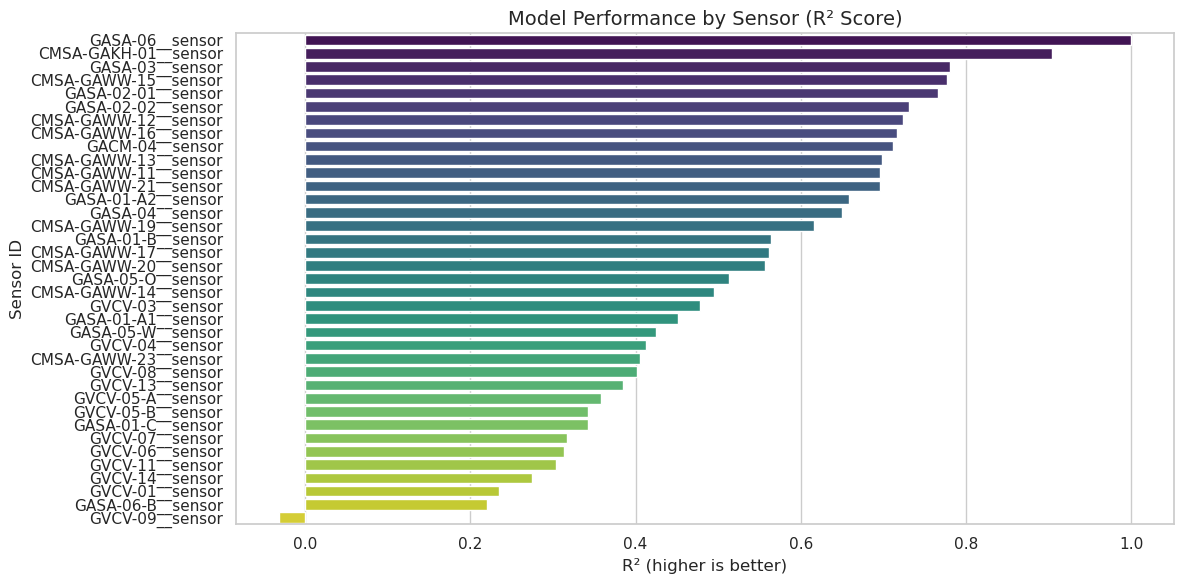

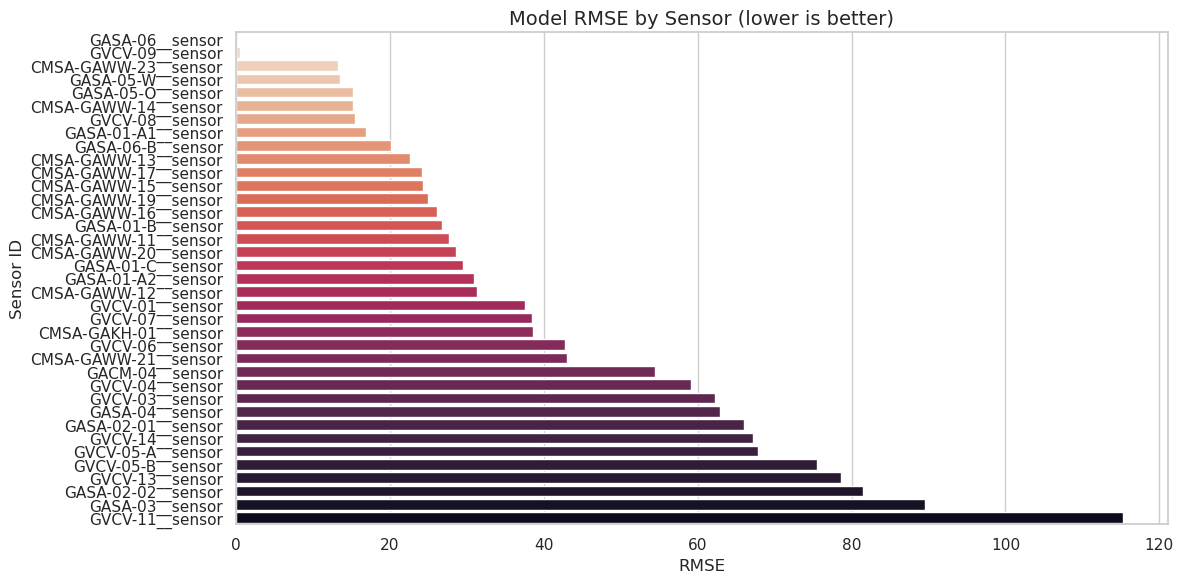

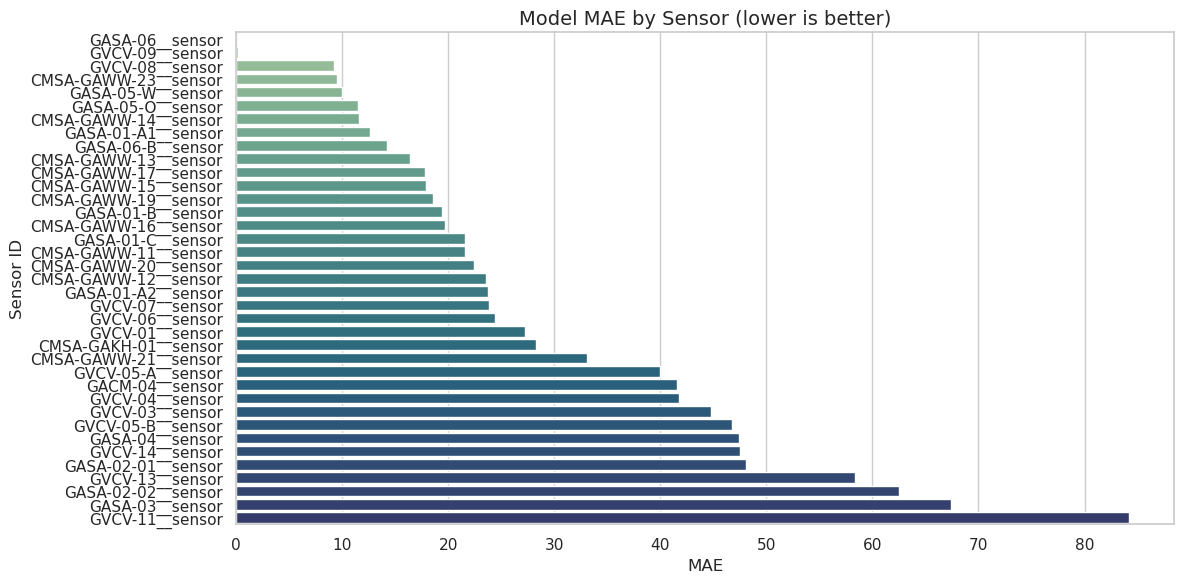

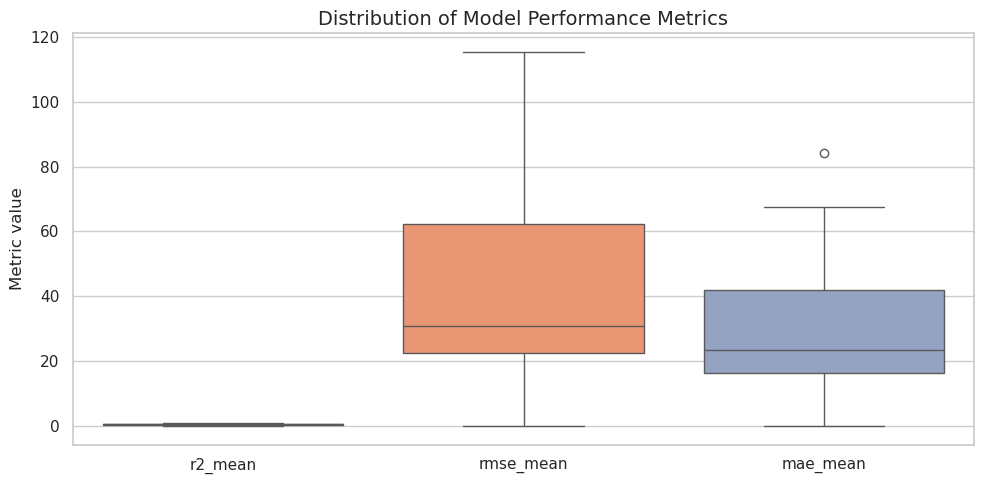


🏆 Top models by R²:


,sensor,r2_mean,rmse_mean,mae_mean
23,GASA-06__sensor,1.000000,0.000000,0.000000
0,CMSA-GAKH-01__sensor,0.903672,38.537640,28.277086
19,GASA-03__sensor,0.781046,89.492602,67.365255
5,CMSA-GAWW-15__sensor,0.777293,24.305907,17.920205
17,GASA-02-01__sensor,0.766572,66.052104,48.062809



⚠️ Worst models by R²:


,sensor,r2_mean,rmse_mean,mae_mean
33,GVCV-09__sensor,-0.031763,0.479581,0.129713
24,GASA-06-B__sensor,0.220768,20.160607,14.269655
25,GVCV-01__sensor,0.234480,37.555655,27.268426
36,GVCV-14__sensor,0.274545,67.119132,47.482183
34,GVCV-11__sensor,0.304083,115.322915,84.226397


In [ ]:
# Visualization of model performance


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- 1) Read result file ---
metrics_path = METRICS_FILE
if not metrics_path.exists():
    raise FileNotFoundError(f"Metrics file not found: {metrics_path}")

dfm = pd.read_csv(metrics_path)
dfm_success = dfm[dfm["status"] == "success"].copy()

if dfm_success.empty:
    raise ValueError("No successful models found — please check training results.")

# --- 2) Basic summary ---
print("Loaded metrics summary:", metrics_path)
print(f"Successful models: {len(dfm_success)} / {len(dfm)}")
print(f"Average R²: {dfm_success['r2_mean'].mean():.3f}")
print(f"Average RMSE: {dfm_success['rmse_mean'].mean():.3f}")
print(f"Average MAE: {dfm_success['mae_mean'].mean():.3f}")

# --- 3) Uniform format ---
sns.set(style="whitegrid", font="DejaVu Sans", rc={"axes.titlesize": 14, "axes.labelsize": 12})

# --- 4) R² Ranking ---
plt.figure(figsize=(12, 6))
df_plot = dfm_success.sort_values("r2_mean", ascending=False)
sns.barplot(x="r2_mean", y="sensor", data=df_plot, palette="viridis")
plt.title("Model Performance by Sensor (R² Score)")
plt.xlabel("R² (higher is better)")
plt.ylabel("Sensor ID")
plt.tight_layout()
plt.savefig(FIGS_DIR / "sensor_r2_ranking.png", dpi=300)
plt.show()

# --- 5) RMSE Ranking ---
plt.figure(figsize=(12, 6))
df_plot = dfm_success.sort_values("rmse_mean", ascending=True)
sns.barplot(x="rmse_mean", y="sensor", data=df_plot, palette="rocket_r")
plt.title("Model RMSE by Sensor (lower is better)")
plt.xlabel("RMSE")
plt.ylabel("Sensor ID")
plt.tight_layout()
plt.savefig(FIGS_DIR / "sensor_rmse_ranking.png", dpi=300)
plt.show()

# --- 6) MAE Ranking ---
plt.figure(figsize=(12, 6))
df_plot = dfm_success.sort_values("mae_mean", ascending=True)
sns.barplot(x="mae_mean", y="sensor", data=df_plot, palette="crest")
plt.title("Model MAE by Sensor (lower is better)")
plt.xlabel("MAE")
plt.ylabel("Sensor ID")
plt.tight_layout()
plt.savefig(FIGS_DIR / "sensor_mae_ranking.png", dpi=300)
plt.show()

# --- 7) Inter-metric distributions ---
plt.figure(figsize=(10, 5))
sns.boxplot(data=dfm_success[["r2_mean", "rmse_mean", "mae_mean"]], palette="Set2")
plt.title("Distribution of Model Performance Metrics")
plt.ylabel("Metric value")
plt.tight_layout()
plt.savefig(FIGS_DIR / "metrics_distribution_boxplot.png", dpi=300)
plt.show()

# --- 8) Output Top-N best and worst models ---
TOP_N = 5
print("\n Top models by R²:")
display(dfm_success.nlargest(TOP_N, "r2_mean")[["sensor", "r2_mean", "rmse_mean", "mae_mean"]])

print("\n Worst models by R²:")
display(dfm_success.nsmallest(TOP_N, "r2_mean")[["sensor", "r2_mean", "rmse_mean", "mae_mean"]])
